In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # the more advanced python visualization library

# sklearn :: utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

    # For Classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# sklearn :: models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

    # For Classification
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# sklearn :: evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Date time
from datetime import datetime

# For distrance calculations between long and lat intersections
import math # from haversine import haversine
# Ref.:https://janakiev.com/blog/gps-points-distance-python/

sns.set_style('whitegrid')

# apply style to all the charts
sns.set_style('whitegrid')

# convert scientific notation to decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Loading clean Dataset

In [2]:
# Load the data
df = pd.read_csv('declarations-exterminations-punaises-de-lit-1.csv')

#### Verify Datatype and make modifications 

In [3]:
# print(df.dtypes)

In [4]:
# Convert 'DATE_INSP_VISPRE', 'DATE_DEBUTTRAIT', and 'DATE_FINTRAIT'

# Ref.:https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
df['DATE_DECLARATION'] = pd.to_datetime(df['DATE_DECLARATION'])
df['DATE_PRIOR_INSP'] = pd.to_datetime(df['DATE_PRIOR_INSP'])
df['DATE_FIRST_EXT'] = pd.to_datetime(df['DATE_FIRST_EXT'])
df['DATE_LAST_EXT'] = pd.to_datetime(df['DATE_LAST_EXT'])

print(df.dtypes)

NO_DECLARATION               int64
DATE_DECLARATION    datetime64[ns]
DATE_PRIOR_INSP     datetime64[ns]
EXT_FREQ                   float64
DATE_FIRST_EXT      datetime64[ns]
DATE_LAST_EXT       datetime64[ns]
HOOD_NUM                    object
HOOD_NAME                   object
BORO_NAME                   object
MTM8_X                     float64
MTM8_Y                     float64
LONGITUDE                  float64
LATITUDE                   float64
LONG_LAT                    object
MTM_X_Y                     object
DEC_MONTH                    int64
DEC_ISSUE                    int64
DATE_DIFF                  float64
dtype: object


#### Dataframe summary

In [5]:
print('Bed bug extermination declarations')
print('')
print('==================COLUMNS==================')
print(df.columns)
print('')
print('==================HEAD==================')
print(df.head())
print('')
print('==================TAIL==================')
print(df.tail())
print('')
print('==================DESCRIBE==================')
print(df.describe())

Bed bug extermination declarations

==================COLUMNS==================
Index(['NO_DECLARATION', 'DATE_DECLARATION', 'DATE_PRIOR_INSP', 'EXT_FREQ',
       'DATE_FIRST_EXT', 'DATE_LAST_EXT', 'HOOD_NUM', 'HOOD_NAME', 'BORO_NAME',
       'MTM8_X', 'MTM8_Y', 'LONGITUDE', 'LATITUDE', 'LONG_LAT', 'MTM_X_Y',
       'DEC_MONTH', 'DEC_ISSUE', 'DATE_DIFF'],
      dtype='object')

==================HEAD==================
   NO_DECLARATION DATE_DECLARATION DATE_PRIOR_INSP  EXT_FREQ DATE_FIRST_EXT  \
0            4254       2012-10-28      2012-09-21      1.00     2012-09-21   
1             830       2011-09-16      2011-07-13      1.00     2011-07-27   
2            1380       2011-11-08      2011-11-02      1.00     2011-11-07   
3             455       2011-08-10      2011-08-09      1.00     2011-08-09   
4            1243       2011-10-26      2011-09-16      1.00     2011-10-05   

  DATE_LAST_EXT HOOD_NUM      HOOD_NAME                            BORO_NAME  \
0    2012-09-21       2

In [6]:
print("df shape:"+str(df.shape) )

df shape:(31241, 18)


In [7]:
df['NO_DECLARATION'].dtype

dtype('int64')

# Feature Engineering

#### Calculate distances between intersections

In [8]:
print('==================TOP_10_BORO==================')
((df.groupby(['BORO_NAME'])
       .agg({'EXT_FREQ': sum, 'NO_DECLARATION':'count'}))
       .sort_values(by = ['EXT_FREQ','NO_DECLARATION'],ascending=False)
       .rename(columns={'EXT_FREQ':'EXT_QT','NO_DECLARATION':'DECL_QT'})
       .head(10))
print('')
print('==================TOP_10_INTERSECTIONS_BASED_ON_EXT_FREQ_AND_ON_DECLARATIONS==================')
((df.groupby(['LONG_LAT','HOOD_NAME','BORO_NAME'])
       .agg({'EXT_FREQ': sum, 'NO_DECLARATION':'count'}))
       .sort_values(by = ['EXT_FREQ','NO_DECLARATION'],ascending=False)
       .rename(columns={'EXT_FREQ':'EXT_QT','NO_DECLARATION':'DECL_QT'})
       .head(10))

==================TOP_10_BORO==================

==================TOP_10_INTERSECTIONS_BASED_ON_EXT_FREQ_AND_ON_DECLARATIONS==================


,,,EXT_QT,DECL_QT
LONG_LAT,HOOD_NAME,BORO_NAME,,
-73.571239_45.584338,Grande-Prairie,Saint-Léonard,352.00,264
-73.68714399999999_45.518173,Grenet,Saint-Laurent,295.00,132
-73.630494_45.509854,Parc-Kent,Côte-des-Neiges–Notre-Dame-de-Grâce,208.00,65
-73.659233_45.569024,Sault-au-Récollet,Ahuntsic-Cartierville,193.00,181
-73.585636_45.527404,Parc-Laurier,Le Plateau-Mont-Royal,189.00,79
-73.600298_45.637873,Marc-Aurèle-Fortin,Rivière-des-Prairies–Pointe-aux-Trembles,181.00,76
-73.61954399999999_45.545823999999996,Crémazie,Villeray–Saint-Michel–Parc-Extension,175.00,73
-73.563652_45.528809,Lorimier,Le Plateau-Mont-Royal,161.00,103
-73.53832299999999_45.543811,Hochelaga,Mercier–Hochelaga-Maisonneuve,161.00,60


Top five Boroughs are Rosemont–La Petite-Patrie, Mercier–Hochelaga-Maisonneuve, Villeray–Saint-Michel–Parc-Extension, Le Plateau-Mont-Royal, and Ville-Marie. 

Top ten intersections are Saint-Léonard, Saint-Laurent, Côte-des-Neiges–Notre-Dame-de-Grâce, Ahuntsic-Cartierville, Rivière-des-Prairies–Pointe-aux-Trembles, Villeray–Saint-Michel–Parc-Extension, Le Plateau-Mont-Royal (2), Mercier–Hochelaga-Maisonneuve, and Ville-Marie, based on the extermination and declaration quantities.

While these to top intersections can individually be considered as epicenters, the top intersection in the Plateau-Mont-Royal is chosen as reference for this analysis, where the coordinates are -73.585636_45.527404 (LONG_LAT).

In [9]:
# Inspication for epicenter calculation:
# https://towardsdatascience.com/transforming-categorical-data-for-usability-in-machine-learning-predictions-90459c3fc967?gi=2253c23cb822

# Ref. : https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1    
    
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2    
    c = 2 * np.arcsin(np.sqrt(a))
    
    km = 6367 * c
    return km

In [10]:
#Epicenter coordinates
plat_lat = [45.527404] # df['LONG_LAT'== -73.585636_45.527404]
plat_lon = [-73.585636]

# Create distance column in dataframe, which returns km values
df['EPI_DIST'] = haversine_np(
    df['LONGITUDE'],df['LATITUDE'], plat_lon,plat_lat)

df['EPI_DIST'].head()

0   8.81
1   6.09
2   2.28
3   6.88
4   2.94
Name: EPI_DIST, dtype: float64

#### Convert most columns to Integer

In [11]:
# Ref. : https://stackoverflow.com/questions/43956335/convert-float64-column-to-int64-in-pandas
# df['DATE_DIFF'] = df['DATE_DIFF'].astype(np.int64)
# df['EXT_FREQ'] = df['EXT_FREQ'].astype(np.int64)

# # Ref.: https://stackoverflow.com/questions/50863691/pandas-convert-date-object-to-int\
# # df['DATE_DECLARATION'].dt.strftime("%Y%m%d").astype(int)
# # df['DATE_PRIOR_INSP'].dt.strftime("%Y%m%d").astype(int)
# # df['DATE_FIRST_EXT'].dt.strftime("%Y%m%d").astype(int)
# # df['DATE_LAST_EXT'].dt.strftime("%Y%m%d").astype(int)

# # Ref.: https://thispointer.com/python-how-to-convert-datetime-object-to-string-using-datetime-strftime/
# # df['DATE_DECLARATION'] = df['DATE_DECLARATION'].strftime("%Y-%b-%d")

# # Ref.: https://stackoverflow.com/questions/47562634/converting-numpy-datetime64-to-long-integer-and-back
# np.datetime64(np.datetime64(df['DATE_DECLARATION']).astype(long), 'ns')

# df.dtypes

#### Create Month and Year Columns 

In [12]:
#We have this for month and year:

df['DEC_D'] = (pd.DatetimeIndex(df['DATE_DECLARATION']).year).map(str) + (
    pd.DatetimeIndex(df['DATE_DECLARATION']).month).map(str)
    
df['PRIOR_D'] = (pd.DatetimeIndex(df['DATE_PRIOR_INSP']).year).map(str) + (
    pd.DatetimeIndex(df['DATE_PRIOR_INSP']).month).map(str)

df['FIRST_D'] = (pd.DatetimeIndex(df['DATE_FIRST_EXT']).year).map(str) + (
    pd.DatetimeIndex(df['DATE_FIRST_EXT']).month).map(str)

df['LAST_D'] = (pd.DatetimeIndex(df['DATE_LAST_EXT']).year).map(str) + (
    pd.DatetimeIndex(df['DATE_LAST_EXT']).month).map(str)

# Create difference between LAST and FIRST Extermination
df['D_DIFF_B'] = round( (df['DATE_LAST_EXT'] - df['DATE_FIRST_EXT'] ) 
                                / np.timedelta64(1,'D') )
    # ['D_DIFF_B'] = ['DATE_LAST_EXT'] - ['DATE_FIRST_EXT']

# Create difference between LAST and FIRST Extermination
df['D_DIFF_C'] = round( (df['DATE_FIRST_EXT'] - df['DATE_PRIOR_INSP'] ) 
                                / np.timedelta64(1,'D') )
    # ['D_DIFF_C'] = ['DATE_FIRST_EXT'] - ['DATE_PRIOR_INSP']

    
# rename column
df['D_DIFF_A'] = df['DATE_DIFF'].copy() # ['D_DIFF_A'] = ['DATE_DECLARATION'] - ['DATE_PRIOR_INSP']

#### Remote unused columns

In [13]:
del df['DEC_MONTH']

del df['HOOD_NUM']
del df['HOOD_NAME']
del df['BORO_NAME']
del df['MTM8_X']
del df['MTM8_Y']
del df['MTM_X_Y']
del df['DEC_ISSUE']

del df['DATE_DIFF']

del df['NO_DECLARATION']
df.dtypes

DATE_DECLARATION    datetime64[ns]
DATE_PRIOR_INSP     datetime64[ns]
EXT_FREQ                   float64
DATE_FIRST_EXT      datetime64[ns]
DATE_LAST_EXT       datetime64[ns]
LONGITUDE                  float64
LATITUDE                   float64
LONG_LAT                    object
EPI_DIST                   float64
DEC_D                       object
PRIOR_D                     object
FIRST_D                     object
LAST_D                      object
D_DIFF_B                   float64
D_DIFF_C                   float64
D_DIFF_A                   float64
dtype: object

### Missing values 

In [14]:
df.isnull().sum()

DATE_DECLARATION    0
DATE_PRIOR_INSP     0
EXT_FREQ            0
DATE_FIRST_EXT      0
DATE_LAST_EXT       0
LONGITUDE           0
LATITUDE            0
LONG_LAT            0
EPI_DIST            0
DEC_D               0
PRIOR_D             0
FIRST_D             0
LAST_D              0
D_DIFF_B            0
D_DIFF_C            0
D_DIFF_A            0
dtype: int64

### Additing intersections as columns

In [15]:
# Ref.: https://github.com/arybressane/CEBD1260-BIG-DATA-ANALYTICS

# intersection to numerical columns
df_inter = pd.get_dummies(df['LONG_LAT'])
df_model = pd.concat([df, df_inter], axis=1).fillna(0.0)

print(list(df_inter.columns))
print('')


['-73.485599_45.698515', '-73.487241_45.695382', '-73.487936_45.649078', '-73.489228_45.693533', '-73.489451_45.689027', '-73.489574_45.644719', '-73.48965600000001_45.688243', '-73.49010899999999_45.653622', '-73.490427_45.639412', '-73.490471_45.651309000000005', '-73.49077199999999_45.649502000000005', '-73.491029_45.63825', '-73.491455_45.675867', '-73.491575_45.694154', '-73.492104_45.650409', '-73.492193_45.645915', '-73.492277_45.641759', '-73.492308_45.6918', '-73.492402_45.635714', '-73.492599_45.648424', '-73.49268199999999_45.640356', '-73.492705_45.635064', '-73.492806_45.649871999999995', '-73.49305600000001_45.694758', '-73.493218_45.634094', '-73.493376_45.673096', '-73.493579_45.672385', '-73.493804_45.638015', '-73.494232_45.632907', '-73.494577_45.654878000000004', '-73.494659_45.636764', '-73.494709_45.692941999999995', '-73.49474599999999_45.651274', '-73.49503_45.66381', '-73.495091_45.658223', '-73.49525600000001_45.643611', '-73.495408_45.666224', '-73.495627_45.

In [16]:
print('================df_model.columns================')
print(list(df_model.columns))

================df_model.columns================
['DATE_DECLARATION', 'DATE_PRIOR_INSP', 'EXT_FREQ', 'DATE_FIRST_EXT', 'DATE_LAST_EXT', 'LONGITUDE', 'LATITUDE', 'LONG_LAT', 'EPI_DIST', 'DEC_D', 'PRIOR_D', 'FIRST_D', 'LAST_D', 'D_DIFF_B', 'D_DIFF_C', 'D_DIFF_A', '-73.485599_45.698515', '-73.487241_45.695382', '-73.487936_45.649078', '-73.489228_45.693533', '-73.489451_45.689027', '-73.489574_45.644719', '-73.48965600000001_45.688243', '-73.49010899999999_45.653622', '-73.490427_45.639412', '-73.490471_45.651309000000005', '-73.49077199999999_45.649502000000005', '-73.491029_45.63825', '-73.491455_45.675867', '-73.491575_45.694154', '-73.492104_45.650409', '-73.492193_45.645915', '-73.492277_45.641759', '-73.492308_45.6918', '-73.492402_45.635714', '-73.492599_45.648424', '-73.49268199999999_45.640356', '-73.492705_45.635064', '-73.492806_45.649871999999995', '-73.49305600000001_45.694758', '-73.493218_45.634094', '-73.493376_45.673096', '-73.493579_45.672385', '-73.493804_45.638015', '-

In [17]:
# Ref.: https://github.com/arybressane/CEBD1260-BIG-DATA-ANALYTICS

# select the columns
    # X input for model
    
X_columns = ['EXT_FREQ', 'LAST_D', 'D_DIFF_C', 'D_DIFF_A','DEC_D','PRIOR_D','FIRST_D','EPI_DIST'
            ] #+ list(df_inter.columns)
    

# measured output Y
y_column = ['D_DIFF_B']
    # Ref.: http://donnees.ville.montreal.qc.ca/dataset/declarations-exterminations-punaises-de-lit/resource/6173de60-c2da-4d63-bc75-0607cb8dcb74
    # Recall DATE_FINTRAIT [now DATE_LAST_EXT] : Date for the end of the last extermination associated to a declaration

print(X_columns)

['EXT_FREQ', 'LAST_D', 'D_DIFF_C', 'D_DIFF_A', 'DEC_D', 'PRIOR_D', 'FIRST_D', 'EPI_DIST']


Using regression, use a model in order to determine the features that help determine lead time from the first extermination, in order to determine the recommended waiting duration prior to entering a dwelwing at an intersection where an extermination previously occured. Factors such as the radius from the intersection are not considered in the model.

An alternative regression would entail in determining the number of declarations, although the number of exterminations is capped at four for each declaration. This alternative is not considered in this model. A classification model can be created to determine whether the extermination occured successfully or not with False Positives and True Negatives, as an indicate that an inspection is needed to verify a future reoccurence.

# Model Training

In [18]:
# threshold = 0.8 
# 80% for train, 20% for test

threshold = 0.8

X = df_model[X_columns]
y = df_model[y_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0-threshold, shuffle=True)

print('==============X_train==============') # X_train
print(X_train.shape)
print(X_train.dtypes)
print('')
print('==============y_train==============') # y_train
print(y_train.shape) 
print(y_train.dtypes)
print('')
print('==============X_test==============') # X_test
print(X_test.shape)
print(X_test.dtypes)
print('')
print('==============y_test==============') # y_test
print(y_test.shape) 
print(y_test.dtypes) 

==============X_train==============
(24992, 8)
EXT_FREQ    float64
LAST_D       object
D_DIFF_C    float64
D_DIFF_A    float64
DEC_D        object
PRIOR_D      object
FIRST_D      object
EPI_DIST    float64
dtype: object

==============y_train==============
(24992, 1)
D_DIFF_B    float64
dtype: object

==============X_test==============
(6249, 8)
EXT_FREQ    float64
LAST_D       object
D_DIFF_C    float64
D_DIFF_A    float64
DEC_D        object
PRIOR_D      object
FIRST_D      object
EPI_DIST    float64
dtype: object

==============y_test==============
(6249, 1)
D_DIFF_B    float64
dtype: object


### Linear Regression

MAE 30.57


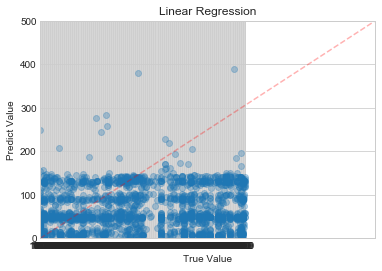

RMAE 121.33


In [19]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print('MAE', round(mae, 2))

plt.scatter(y_test, y_pred, alpha=0.3)

plt.plot(range(0,500, 1), range(0,500, 1), '--r', alpha=0.3, label='Line1')

plt.title('Linear Regression')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.xlim([0, 500])
plt.ylim([0, 500])
plt.show()

#calculate the RMSE
RMAE = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMAE', round(RMAE, 2))

### KNN

In [20]:
model = KNeighborsRegressor(10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print('MAE', round(mae, 2))

MAE 19.17


### Decision Tree

In [21]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print('MAE', round(mae, 2))

MAE 16.5


# Experiments

Linear Regression
MAE 30.565414650288446
RMSE 121.33235144860676


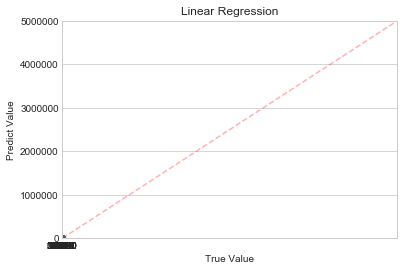


KNN 5
MAE 17.288718194911183
RMSE 88.05738029464592


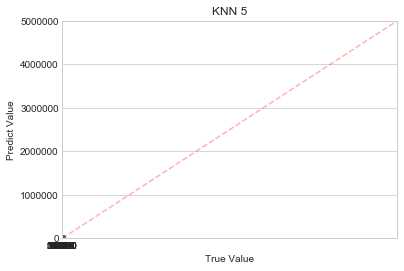


KNN 2
MAE 15.54928788606177
RMSE 72.25849103270987


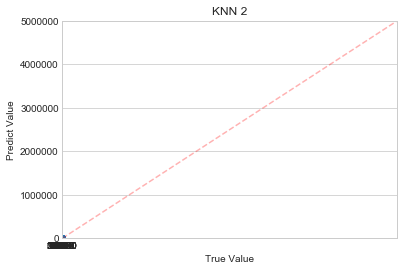


Decision Tree
MAE 16.24377233690724
RMSE 111.9984558930942


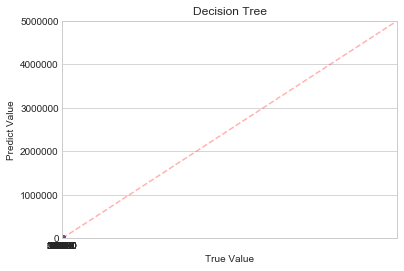

C:\Users\outpost\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Random Forest 10
MAE 14.274594868512295
RMSE 81.91579718677615


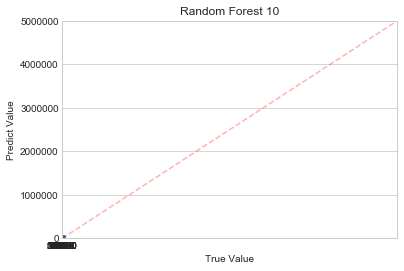

C:\Users\outpost\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Random Forest 100
MAE 13.577110425287094
RMSE 75.90265445802991


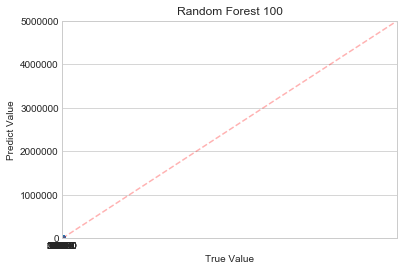

In [22]:
# Ref.: https://github.com/arybressane/CEBD1260-BIG-DATA-ANALYTICS/blob/master/week5/regression-house-sklearn-ext-class-version.ipynb

def model_training(model_name, model, X_train, y_train):
    model.fit(X_train, y_train)
    return model
    
def model_prediction(model, X_test):
    y_pred = model.predict(X_test)
    return y_pred

def model_evaluation(model_name, y_test, y_pred):
    print(model_name)
    print('MAE', mean_absolute_error(y_test, y_pred))
    print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot(range(0,5000000, 100), range(0,5000000, 100), '--r', alpha=0.3, label='Line1')
    plt.title(model_name)
    plt.xlabel('True Value')
    plt.ylabel('Predict Value')
    plt.xlim([0, 5000000])
    plt.ylim([0, 5000000])
    plt.show()
    print('')

def run_experiment(model_name, model, X_train, y_train, X_test):
    train_model = model_training(model_name, model, X_train, y_train)
    predictions = model_prediction(train_model, X_test)
    model_evaluation(model_name, y_test, predictions)
    
run_experiment('Linear Regression', LinearRegression(), X_train, y_train, X_test)
run_experiment('KNN 5', KNeighborsRegressor(5), X_train, y_train, X_test)
run_experiment('KNN 2', KNeighborsRegressor(2), X_train, y_train, X_test)
run_experiment('Decision Tree', DecisionTreeRegressor(), X_train, y_train, X_test)
run_experiment('Random Forest 10', RandomForestRegressor(10), X_train, y_train, X_test)
run_experiment('Random Forest 100', RandomForestRegressor(100), X_train, y_train, X_test)

# Error Analysis

In [23]:
# Ref.: https://github.com/arybressane/CEBD1260-BIG-DATA-ANALYTICS/blob/master/week5/regression-house-sklearn-ext-class-version.ipynb

model = RandomForestRegressor(100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\outpost\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [24]:
#for i in range(len(X_test.columns)):
fi = []
for i, col in enumerate(X_test.columns):
    fi.append([col, model.feature_importances_[i]])
pd.DataFrame(fi).sort_values(1, ascending=False)

,0,1
1,LAST_D,0.42
2,D_DIFF_C,0.17
7,EPI_DIST,0.10
0,EXT_FREQ,0.08
6,FIRST_D,0.07
5,PRIOR_D,0.06
3,D_DIFF_A,0.05
4,DEC_D,0.05


In [25]:
df_test = pd.DataFrame(X_test).copy()
df_test['price'] = y_test
df_test['prediction'] = y_pred
df_test['abs_error'] = abs(df_test['price']-df_test['prediction'])
df_test.sort_values(by='abs_error', ascending=False).round()

,EXT_FREQ,LAST_D,D_DIFF_C,D_DIFF_A,DEC_D,PRIOR_D,FIRST_D,EPI_DIST,price,prediction,abs_error
3923,1.00,202311,0.00,20.00,201311,201311,201311,4.00,3652.00,275.00,3377.00
14000,1.00,20312,-28.00,8.00,20133,20133,20132,4.00,6574.00,3885.00,2689.00
24641,1.00,201111,-2557.00,2.00,201811,201811,201111,4.00,0.00,2043.00,2043.00
14343,1.00,20194,0.00,0.00,20184,20184,20184,6.00,363.00,1393.00,1030.00
26910,2.00,201411,8.00,0.00,201110,201110,201110,5.00,1128.00,164.00,964.00
3569,1.00,20186,6.00,136.00,201510,20156,20156,7.00,1096.00,166.00,930.00
25040,4.00,20181,181.00,313.00,20183,20174,201710,0.00,88.00,897.00,809.00
2116,2.00,201711,0.00,5.00,201512,201512,201512,7.00,704.00,43.00,661.00
14704,2.00,201710,8.00,41.00,201512,201511,201511,8.00,712.00,52.00,660.00
9751,4.00,20168,22.00,36.00,20128,20127,20127,0.00,1474.00,862.00,612.00


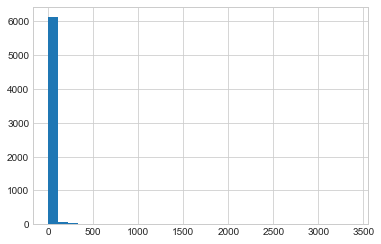

In [26]:
plt.hist(df_test['abs_error'], bins=30)
plt.show()

In [27]:
df_error = df_test[df_test['abs_error']>0]
df_error

,EXT_FREQ,LAST_D,D_DIFF_C,D_DIFF_A,DEC_D,PRIOR_D,FIRST_D,EPI_DIST,price,prediction,abs_error
5790,4.00,20141,0.00,7.00,201312,201312,201312,1.69,42.00,46.95,4.95
15275,1.00,20182,0.00,2.00,20182,20182,20182,2.20,0.00,0.53,0.53
21370,1.00,201212,164.00,31.00,20128,20127,201212,1.89,0.00,3.54,3.54
9838,1.00,20138,0.00,37.00,20139,20138,20138,10.58,0.00,0.12,0.12
1947,1.00,20134,7.00,8.00,20134,20133,20134,1.08,0.00,0.08,0.08
28530,1.00,20149,0.00,4.00,20149,20149,20149,1.72,0.00,0.64,0.64
15583,1.00,201511,0.00,25.00,201512,201511,201511,12.80,0.00,2.02,2.02
22781,2.00,20133,0.00,7.00,20133,20133,20133,4.65,0.00,0.04,0.04
3413,2.00,20139,1.00,35.00,20139,20138,20138,3.40,27.00,22.13,4.87
15225,4.00,20177,7.00,10.00,20173,20173,20173,2.34,105.00,117.57,12.57


In [28]:
df_error.describe()

,EXT_FREQ,D_DIFF_C,D_DIFF_A,EPI_DIST,price,prediction,abs_error
count,5119.00,5119.00,5119.00,5119.00,5119.00,5119.00,5119.00
mean,1.60,8.38,36.54,5.14,34.34,33.62,16.62
std,0.98,101.15,71.15,3.36,144.83,107.49,83.11
min,1.00,-3650.00,-332.00,0.00,0.00,0.00,0.00
25%,1.00,0.00,6.00,2.61,0.00,0.71,0.66
50%,1.00,0.00,18.00,4.28,0.00,3.99,2.88
75%,2.00,5.00,41.00,7.19,29.00,34.61,11.41
max,4.00,2457.00,2457.00,23.70,6574.00,3885.26,3377.40


In [29]:
df_error.corr()['abs_error'].dropna().sort_values()

D_DIFF_C     -0.15
EPI_DIST      0.00
D_DIFF_A      0.02
EXT_FREQ      0.14
prediction    0.58
price         0.73
abs_error     1.00
Name: abs_error, dtype: float64

# Cross Validation

In [30]:
models = [
    ('LinearRegression', LinearRegression()),
    ('RandomForestRegressor10', RandomForestRegressor(n_estimators=10)),
    ('RandomForestRegressor100', RandomForestRegressor(n_estimators=100, n_jobs=4)),
    ('KNeighborsRegressor', KNeighborsRegressor()),
    ('DecisionTreeRegressor', DecisionTreeRegressor())
]

k = 10
results = {}
for m in models:
     print('MODEL', m[0])
     results[m[0]] = {'mae':[], 'rmse':[]}
     kf = KFold(n_splits=k)
     for train_index, test_index in kf.split(X):
         X_train_k, X_test_k = X.values[train_index], X.values[test_index]
         y_train_k, y_test_k = y.values[train_index], y.values[test_index]
        
         model = m[1]
         model.fit(X_train_k, y_train_k.ravel())
         y_pred = model.predict(X_test_k)
            
         mae = mean_absolute_error(y_test_k, y_pred)
         rmse = np.sqrt(mean_squared_error(y_test_k, y_pred))
            
         results[m[0]]['mae'].append(mae)
         results[m[0]]['rmse'].append(rmse)

MODEL LinearRegression
MODEL RandomForestRegressor10
MODEL RandomForestRegressor100
MODEL KNeighborsRegressor
MODEL DecisionTreeRegressor


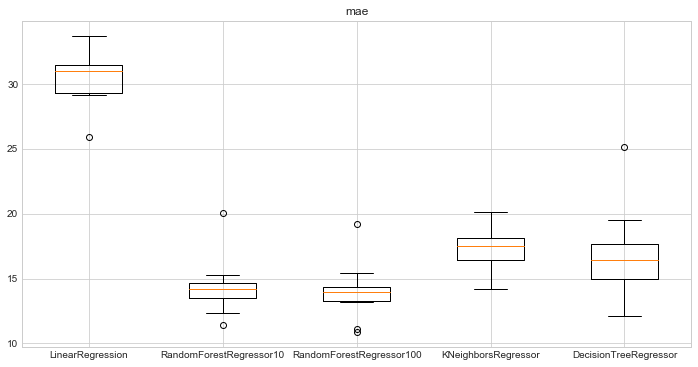

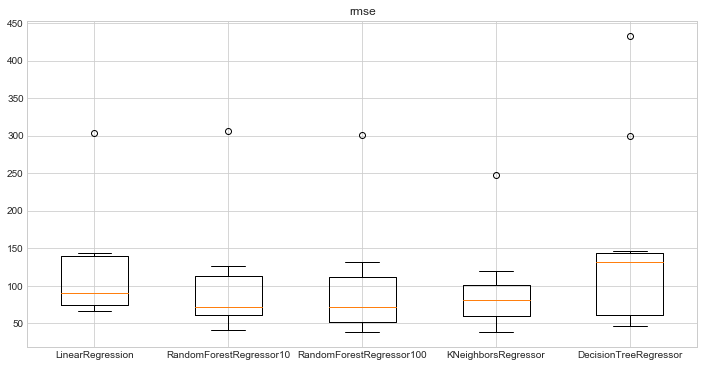

In [31]:
for metric in ['mae', 'rmse']:
     values = []
     labels = []
     for model, result_values in results.items():
         for m, v in result_values.items():
             if m == metric:
                 labels.append(model)
                 values.append(v)
                    
     plt.figure(figsize=(12,6))
     plt.title(metric)
     plt.boxplot(values)
     plt.xticks(range(1, len(labels)+1), labels, rotation='horizontal')
     plt.show()

# Commentary